In [23]:
import numpy as np
import pandas as pd

On se connecte à la base de données

In [24]:
from db_utils import get_db_engine

# Obtenir le moteur de base de données
engine = get_db_engine()

In [25]:
# Charger les fichiers sources
file1 = 'data\\ObesityDataSet_raw_and_data_sinthetic.csv'
file2 = 'data\\DietSurvey_toJson.json'

# Charger les fichiers dans des DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_json(file2)


In [26]:
# drinks1 - df1
drinks1 = df1[['SCC', 'CH2O']].rename(
    columns={
        'SCC': 'sugary_con',
        'CH2O': 'water_con'
    }
)
drinks1['alcohol_con'] = None  # Pas de colonne correspondante dans df1

print("drinks1 préparé.")

# drinks2 - df2
drinks2 = df2[
    [
        "What is your water consumption like (in a day, 1 cup=250ml approx)",
        "How frequently do you consume these beverages [Aerated (Soft) Drinks]",
        "How frequently do you consume these beverages [Alcoholic Beverages]"
    ]
].rename(
    columns={
        "What is your water consumption like (in a day, 1 cup=250ml approx)": "water_con",
        "How frequently do you consume these beverages [Alcoholic Beverages]": "alcohol_con",
        "How frequently do you consume these beverages [Aerated (Soft) Drinks]": "sugary_con"
    }
)

print("drinks2 préparé.")


drinks1 préparé.
drinks2 préparé.


In [27]:
# Fonction pour convertir la note en catégorie 'water_con'
def categorize_water_con(note):
    if note >= 2.7:
        return 'More than 15 cups'
    elif note >= 2.3:
        return '11-14 cups'
    elif note >= 1.7:
        return '7-10 cups'
    elif note >= 1.0:
        return '4-6 cups'
    else:
        return 'Less than 3 cups'

# Appliquer la fonction à la colonne 'water_con' de food_habits1
drinks1 ['water_con'] = drinks1 ['water_con'].apply(categorize_water_con)

In [28]:
import numpy as np

# Définir les options pour "yes"
yes_options = ['Once a month', 'Few times a week', 'Less often']

# Appliquer la transformation
drinks1['sugary_con'] = drinks1['sugary_con'].apply(
    lambda x: 'Never' if x == 'no' else np.random.choice(yes_options)
)

print(drinks1.head())


   sugary_con          water_con alcohol_con
0       Never          7-10 cups        None
1  Less often  More than 15 cups        None
2       Never          7-10 cups        None
3       Never          7-10 cups        None
4       Never          7-10 cups        None


In [29]:
# Concatenation des DataFrames préparés
drinks = pd.concat([drinks1, drinks2], ignore_index=True)
print("Drinks combiné.")

Drinks combiné.


In [30]:
# Fonction pour générer un nombre aléatoire dans les plages de chaque catégorie
def randomize_water_con(value):
    if value == 'More than 15 cups':
        return np.random.randint(15, 25)  # Entre 15 et 20
    elif value == '11-14 cups':
        return np.random.randint(11, 14)  # Entre 11 et 14
    elif value == '7-10 cups':
        return np.random.randint(7, 10)   # Entre 7 et 10
    elif value == '4-6 cups':
        return np.random.randint(4, 6)    # Entre 4 et 6
    elif value == 'Less than 3 cups':
        return np.random.randint(0, 3)    # Entre 0 et 3
    else:
        return value

# Appliquer la fonction à la colonne 'water_con' de food_habits
drinks['water_con'] = drinks['water_con'].apply(randomize_water_con)


In [31]:
drinks

,sugary_con,water_con,alcohol_con
0,Never,8,None
1,Less often,21,None
2,Never,8,None
3,Never,9,None
4,Never,7,None
...,...,...,...
2184,Once a day,8,Few times a week
2185,Never,24,Few times a week
2186,Once a month,7,Never
2187,Once a month,5,Few times a week


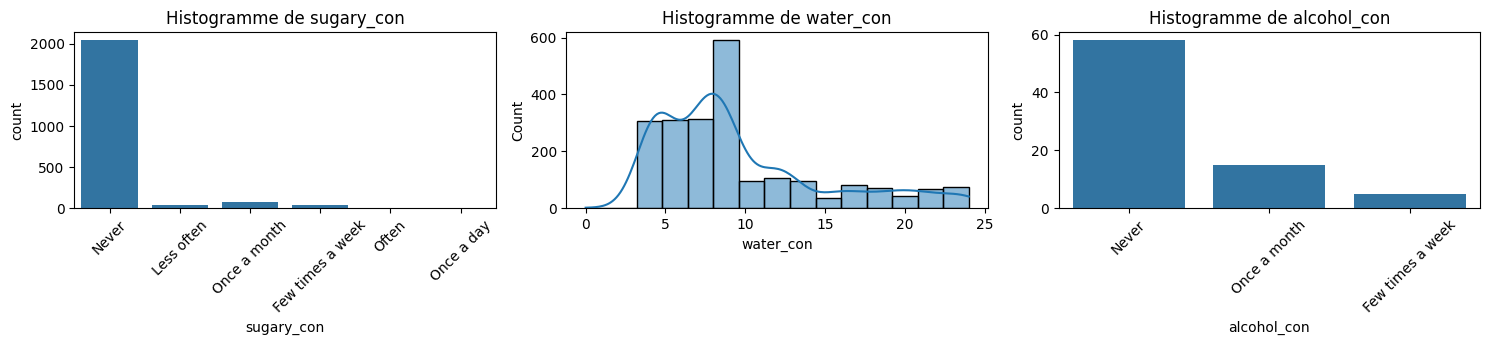

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Définir la taille de la figure pour afficher plusieurs graphes
plt.figure(figsize=(15, 15))

# Loop à travers chaque colonne du DataFrame pour créer un histogramme
for i, column in enumerate(drinks.columns):
    plt.subplot(5, 3, i + 1)  # 5 lignes, 3 colonnes pour organiser les graphiques
    if drinks[column].dtype == 'object':  # Si la colonne est catégorielle
        sns.countplot(data=drinks, x=column)
        plt.title(f'Histogramme de {column}')
        plt.xticks(rotation=45)
    else:  # Si la colonne est numérique
        sns.histplot(drinks[column], kde=True, bins=15)
        plt.title(f'Histogramme de {column}')
    
    plt.tight_layout()  # Ajuster l'espacement entre les graphiques

# Afficher tous les graphiques
plt.show()


In [34]:
# Obtenir les lignes uniques
unique_rows = drinks.drop_duplicates()

# Afficher les lignes uniques
unique_rows


,sugary_con,water_con,alcohol_con
0,Never,8,None
1,Less often,21,None
3,Never,9,None
4,Never,7,None
10,Never,21,None
...,...,...,...
2181,Once a day,7,Never
2183,Never,8,Once a month
2184,Once a day,8,Few times a week
2185,Never,24,Few times a week


In [35]:
# Supprimer les doublons pour conserver uniquement les lignes uniques
drinks_unique = drinks.drop_duplicates().reset_index(drop=True)

# Ajouter la colonne 'id_drinks' avec des valeurs incrémentées
drinks_unique.insert(0, 'id_drinks', range(1, len(drinks_unique) + 1))

# Afficher le DataFrame modifié
print(drinks_unique)


    id_drinks    sugary_con  water_con       alcohol_con
0           1         Never          8              None
1           2    Less often         21              None
2           3         Never          9              None
3           4         Never          7              None
4           5         Never         21              None
..        ...           ...        ...               ...
90         91    Once a day          7             Never
91         92         Never          8      Once a month
92         93    Once a day          8  Few times a week
93         94         Never         24  Few times a week
94         95  Once a month          5  Few times a week

[95 rows x 4 columns]


In [36]:
drinks_unique.to_sql('Drinks', engine, if_exists='append', index=False)

print("Les données ont été insérées avec succès dans la table 'Diet'.")


Les données ont été insérées avec succès dans la table 'Diet'.


C:\Users\user\AppData\Local\Temp\ipykernel_20292\3162262561.py:1: UserWarning: The provided table name 'Drinks' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  drinks_unique.to_sql('Drinks', engine, if_exists='append', index=False)
